## Construct background model

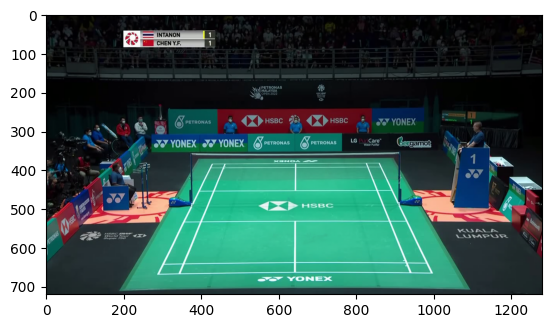

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Fix random seed
np.random.seed(0)

cap = cv2.VideoCapture("input1.mp4")

frames = []

# Randomly sample 50 frames
for i in range(50):
    cap.set(cv2.CAP_PROP_POS_FRAMES, np.random.randint(0, cap.get(cv2.CAP_PROP_FRAME_COUNT)))
    ret, frame = cap.read()
    frames.append(frame)

cap.release()

image = np.median(frames, axis=0).astype(np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

height, width = image.shape[:2]


## Line pixel detection

/tmp/ipykernel_932292/1201662458.py:12: RuntimeWarning: overflow encountered in scalar subtract
  and gray[i, j] - gray[i, j - dist_tau] > intensity_threshold
/tmp/ipykernel_932292/1201662458.py:13: RuntimeWarning: overflow encountered in scalar subtract
  and gray[i, j] - gray[i, j + dist_tau] > intensity_threshold
/tmp/ipykernel_932292/1201662458.py:22: RuntimeWarning: overflow encountered in scalar subtract
  and gray[i, j] - gray[i + dist_tau, j] > intensity_threshold
/tmp/ipykernel_932292/1201662458.py:21: RuntimeWarning: overflow encountered in scalar subtract
  and gray[i, j] - gray[i - dist_tau, j] > intensity_threshold


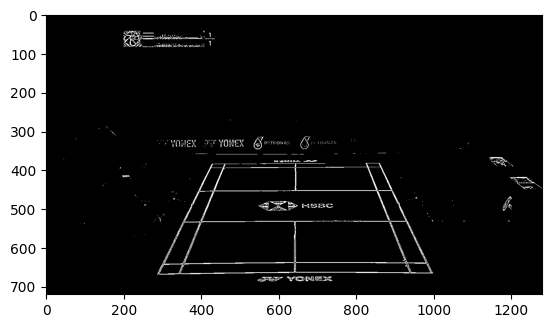

In [14]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

dist_tau = 3
intensity_threshold = 40

filtered = np.zeros_like(gray)

for i in range(len(gray)):
    for j in range(dist_tau, len(gray[0]) - dist_tau):
        if (
            gray[i, j] > 190
            and gray[i, j] - gray[i, j - dist_tau] > intensity_threshold
            and gray[i, j] - gray[i, j + dist_tau] > intensity_threshold
        ):
            filtered[i, j] = 255

for i in range(dist_tau, len(gray) - dist_tau):
    for j in range(len(gray[0])):
        if (
            gray[i, j] > 190
            and gray[i, j] - gray[i - dist_tau, j] > intensity_threshold
            and gray[i, j] - gray[i + dist_tau, j] > intensity_threshold
        ):
            filtered[i, j] = 255

plt.imshow(filtered, cmap="gray")


## Hough transform

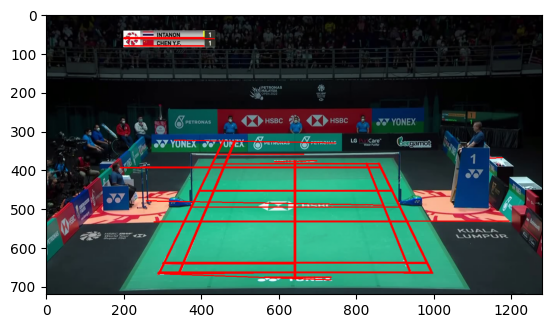

In [15]:
lines = cv2.HoughLinesP(filtered, 1, np.pi / 180, 90, np.array([]), 10, 250)
# lines = cv2.HoughLinesP(filtered, 1, np.pi / 180, 80, np.array([]), 100, 20)

lines = np.squeeze(lines)

line_image = image.copy()
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(line_image)


## Extracting horizontal and vertical lines

In [16]:
def classify_lines(lines):
    h_lines = []
    v_lines = []

    highest_vertical_y = np.inf
    lowest_vertical_y = 0

    for line in lines:
        x1, y1, x2, y2 = line
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)

        if dx > 2 * dy:
            # if dy < 0.5:
            h_lines.append(line)
        else:
            v_lines.append(line)
            highest_vertical_y = min(highest_vertical_y, y1, y2)
            lowest_vertical_y = max(lowest_vertical_y, y1, y2)

    court_h_lines = []
    for line in h_lines:
        x1, y1, x2, y2 = line
        if lowest_vertical_y > y1 > highest_vertical_y:
            court_h_lines.append(line)

    return court_h_lines, v_lines


def classify_vertical_lines(v_lines, width):
    left_v_lines = []
    right_v_lines = []

    left_th = width / 3
    right_th = width * 2 / 3

    for line in v_lines:
        x1, y1, x2, y2 = line
        if x1 < left_th or x2 < left_th:
            left_v_lines.append(line)
        elif x1 > right_th or x2 > right_th:
            right_v_lines.append(line)

    return left_v_lines, right_v_lines


h_lines, v_lines = classify_lines(lines)
(
    left_v_lines,
    right_v_lines,
) = classify_vertical_lines(v_lines, width)


print(f"Total number of lines: {len(lines)}")
print(f"Number of horizontal lines: {len(h_lines)}")
print(f"Number of left vertical lines: {len(left_v_lines)}")
print(f"Number of right vertical lines: {len(right_v_lines)}")


Total number of lines: 57
Number of horizontal lines: 32
Number of left vertical lines: 8
Number of right vertical lines: 8


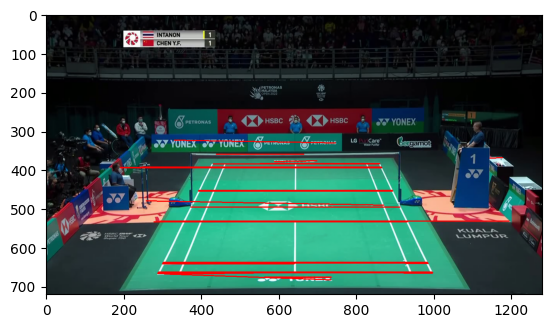

In [17]:
# Plot horizontal lines
h_line_image = image.copy()
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(h_line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(h_line_image)


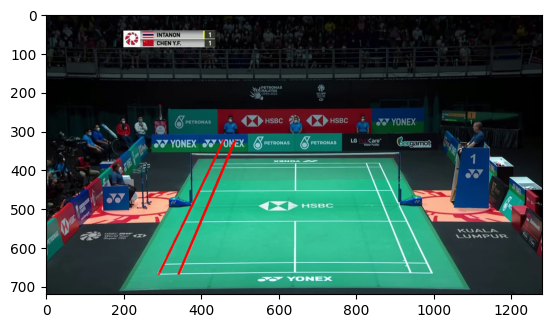

In [18]:
# Plot left vertical lines
left_v_line_image = image.copy()
for line in left_v_lines:
    x1, y1, x2, y2 = line
    cv2.line(left_v_line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(left_v_line_image)


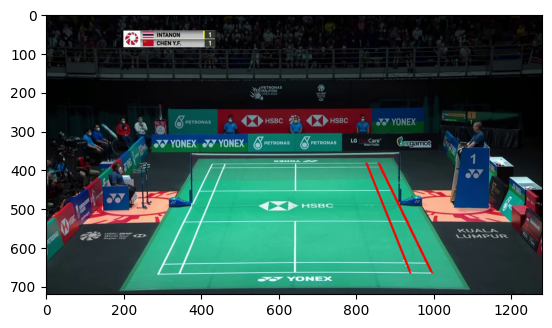

In [19]:
# Plot right vertical lines
right_v_line_image = image.copy()
for line in right_v_lines:
    x1, y1, x2, y2 = line
    cv2.line(right_v_line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(right_v_line_image)


## Merge duplicate lines

In [20]:
def merge_horizontal_lines(h_lines):
    merged_h_lines = []
    # Merge horizontal lines
    h_lines = sorted(h_lines, key=lambda x: x[0])
    merged = [False] * len(h_lines)
    for i, line in enumerate(h_lines):
        if merged[i]:
            continue

        for j, line_2 in enumerate(h_lines[i + 1 :]):
            if merged[i + j + 1]:
                continue

            x1, y1, x2, y2 = line
            x3, y3, x4, y4 = line_2
            dy = abs(y3 - y2)
            if dy < 5:
                points = sorted(
                    [(x1, y1), (x2, y2), (x3, y3), (x4, y4)], key=lambda x: x[0]
                )
                line = np.array([*points[0], *points[-1]])
                merged[i + j + 1] = True

        merged_h_lines.append(line)

    return merged_h_lines


merged_h_lines = merge_horizontal_lines(h_lines)

print(f"Number of merged horizontal lines: {len(merged_h_lines)}")


Number of merged horizontal lines: 13


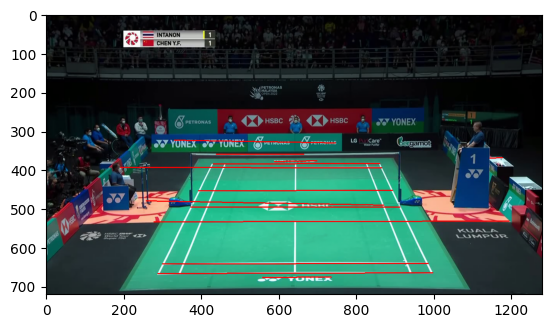

In [21]:
# Plot horizontal lines
h_line_image = image.copy()
for line in merged_h_lines:
    x1, y1, x2, y2 = line
    cv2.line(h_line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(h_line_image)

In [22]:
def line_intersection(line1, line2):
    """
    Find 2 lines intersection point
    """
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    # Check if lines are parallel
    if (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4) == 0:
        return None

    # Find intersection point
    x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / (
        (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    )
    y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / (
        (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    )

    return int(x), int(y)


def merge_vertical_lines(v_lines):
    merged_v_lines = []

    v_lines = sorted(v_lines, key=lambda x: x[1])
    xl, yl, xr, yr = (0, height * 6 / 7, width, height * 6 / 7)
    merged = [False] * len(v_lines)
    for i, line in enumerate(v_lines):
        if merged[i]:
            continue

        for j, line_2 in enumerate(v_lines[i + 1 :]):
            if merged[i + j + 1]:
                continue

            x1, y1, x2, y2 = line
            x3, y3, x4, y4 = line_2

            xi, yi = line_intersection(line, (xl, yl, xr, yr))
            xj, yj = line_intersection(line_2, (xl, yl, xr, yr))

            dx = abs(xi - xj)
            if dx < 10:
                points = sorted(
                    [(x1, y1), (x2, y2), (x3, y3), (x4, y4)], key=lambda x: x[1]
                )
                line = np.array([*points[0], *points[-1]])
                merged[i + j + 1] = True

        merged_v_lines.append(line)

    return merged_v_lines


merged_left_v_lines = merge_vertical_lines(left_v_lines)
merged_right_v_lines = merge_vertical_lines(right_v_lines)

print(f"Number of merged left vertical lines: {len(merged_left_v_lines)}")
print(f"Number of merged right vertical lines: {len(merged_right_v_lines)}")


Number of merged left vertical lines: 2
Number of merged right vertical lines: 2


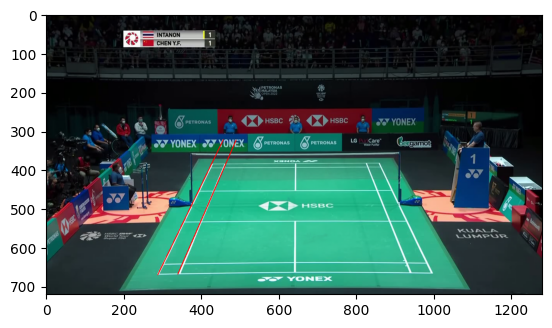

In [23]:
# Plot left vertical lines
left_v_line_image = image.copy()
for line in merged_left_v_lines:
    x1, y1, x2, y2 = line
    cv2.line(left_v_line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(left_v_line_image)


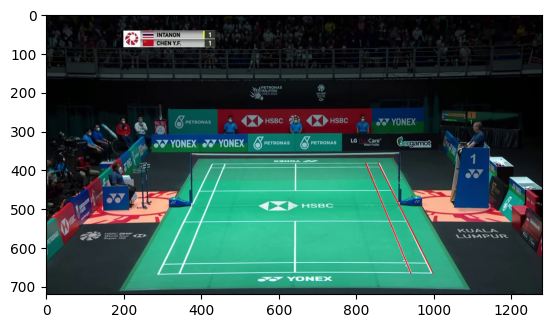

In [24]:
# Plot right vertical lines
right_v_line_image = image.copy()
for line in merged_right_v_lines:
    x1, y1, x2, y2 = line
    cv2.line(right_v_line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(right_v_line_image)


## 